[Found /root/Downloads/MEGAM/megam-64.opt: /root/Downloads/MEGAM/megam-64.opt]
[55.0, 82.0, 16.1, 27.0]
[87.7, 70.6, 67.8, 69.2]
[92.9, 79.9, 86.8, 83.2]
[93.3, 82.3, 86.8, 84.5]
[94.2, 83.3, 88.4, 85.7]


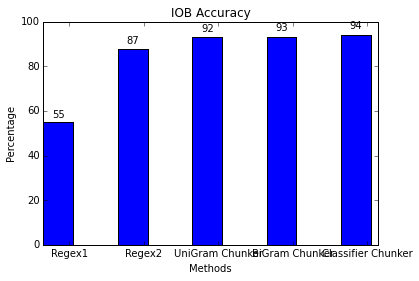

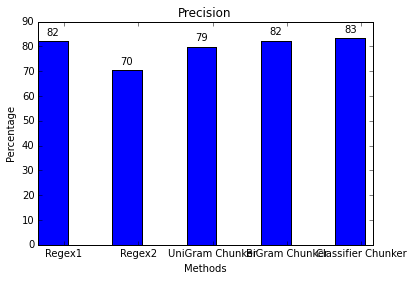

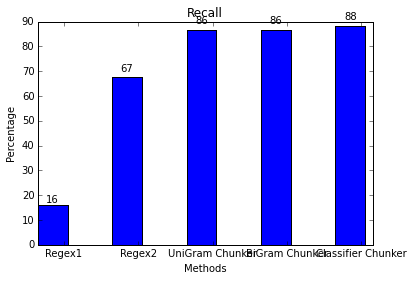

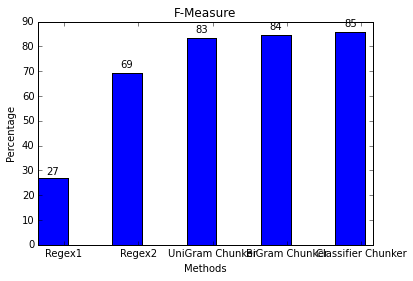

In [21]:
import nltk
from nltk.corpus import conll2000
import numpy as np
import matplotlib.pyplot as plt
nltk.config_megam('/root/Downloads/MEGAM/megam-64.opt')
import newspaper
import urllib
from newspaper import Article
import re
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import brown
%matplotlib inline
#Using 3 different ways to Chunk the cornl2000 corpus
#Type 1. Regex 
#Type 2. Unigram / Bigram Chunk Tagger
#Type 3. Chunk classifier.
#Choose the best one by comparing the various statistic ==> Accuracy, Precision, Recall, F-measure.3
#print(conll2000.chunked_sents('train.txt')[1])
#Baseline Performance to see how many grammar = ""    ##BaseLine Performance.
#grammar = r"NP: {<[CDJNP].*>+}"                     ## Using Regex1 to find the Chunks
#grammar = r"NP: {<DT.?><JJ.?><NN.?>+}" ##Using Regex2 to find Chunks

#Function to remove the '%' sign from the data, then scrub it and return the 4 statistics for visualisation.
def percent_removal(evaluation):
    final_stats = []
    stats = str(evaluation).split('\n')
    stats = stats[1:]
    for i in range(len(stats)):
        val = (stats[i].split(':')[1].split('%')[0]).strip()
        final_stats.append(float(val))
    print final_stats
    return final_stats

#Graphing the statistics that were calculated for comparing all the models.
def visualisation(score,title):
    score = [i for i in score]
    N = 5
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars
    fig, ax = plt.subplots()
    bar = ax.bar(ind, score, width = 0.4, color='blue')
    ax.set_xlabel("Methods")
    ax.set_ylabel("Percentage")
    ax.set_title(title)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(('Regex1', 'Regex2', 'UniGram Chunker', 'BiGram Chunker' , 'Classifier Chunker'))
    for rect in bar:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                    '%d' % int(height),
                    ha='center', va='bottom')
    plt.show()

#Function for the Regex Chunker. Used 2 types for Regex for Chunking.    
def Chunker_regex(grammar):
    parser = nltk.RegexpParser(grammar)
    testing_set = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
    evaluation = str(parser.evaluate(testing_set))
    return evaluation
  
#Chunker_regex(r"NP: {<DT.?><JJ.?><NN.?>+}")  
Grammar1 = r"NP: {<DT.?><JJ>*<NN>}" 
Grammar2 = r"NP: {<[CDJNP].*>+}"

x_axis = ['IOB Accuracy' , 'Precision' , 'Recall' , 'F-Measure']
s1 = percent_removal(Chunker_regex(Grammar1))
s2 = percent_removal(Chunker_regex(Grammar2))

#Implementing the Unigram Chunker.
class UnigramChunker(nltk.ChunkParserI):
    
    def __init__(self, train_sents): 
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data) 

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        
        return nltk.chunk.util.conlltags2tree(conlltags)
    
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

unigram_chunker= UnigramChunker(train_sents)
s3 = percent_removal(unigram_chunker.evaluate(test_sents))

# Implementing the Bigram Chunker
class BigramChunker(nltk.ChunkParserI):
    
    def __init__(self, train_sents): 
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data) 

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        
        return nltk.chunk.util.conlltags2tree(conlltags)
    
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

bigram_chunker= BigramChunker(train_sents)
s4 = percent_removal(bigram_chunker.evaluate(test_sents))

# Implementing Clasifier based Chunkers

class ConsecutiveNPChunkTagger(nltk.TaggerI): 

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) 
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train( 
            train_set, algorithm='megam', trace=0)
        
#Function used for tagging the sentences.
    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.util.conlltags2tree(conlltags)
    
def npchunk_features(sentence, i, history):
        word, pos = sentence[i]
        if i == 0:
            prevword, prevpos = "<START>", "<START>"
        else:
            prevword, prevpos = sentence[i-1]
        return {"pos": pos, "word": word, "prevpos": prevpos}
chunker = ConsecutiveNPChunker(train_sents)

s5 = percent_removal(chunker.evaluate(test_sents))

stats = zip(s1,s2,s3,s4,s5)

for i in range(len(stats)):
    visualisation(stats[i],x_axis[i])

In [22]:
#Creating a Punkt tokenizer to tokenize the words in the sentence.
#Used sent_tokenize to tokenize the individual sentences.
from nltk.tokenize import sent_tokenize
def tokenize_with_punct(text):
    text = text.lower()
    regex =  re.findall(r'[\w]+|[\W] ', text)
    punkt_token = [i for i in regex if i !=' ']
    return punkt_token
#tokenize_with_punct(scrubbed_article)
urls = []
cnn_ob = newspaper.build('http://cnn.com')
for article in cnn_ob.articles:
    urls.append(article.url)
first_ten_urls = urls[:10]
#Taking a Sample article for Chunking.
url = u'http://fox13now.com/2013/12/30/new-year-new-laws-obamacare-pot-guns-and-drones/'
#url = u'http://cnn.com/2016/02/22/opinions/supreme-court-posner-broyde/index.html'
#uel = u'https://cnn.com/2016/02/23/news/economy/currency-comeback-oil/index.html'
article = Article(url)
article.download()
article.parse()
article_new_line = article.text.split('\n')
article_new_line = [i for i in article_new_line if len(i) > 0]
scrubbed_article = (' '.join(article_new_line))
test_data =  sent_tokenize(scrubbed_article)
#print test_data
testing_set = []
for i in range(len(test_data)):
    testing_set.append(tokenize_with_punct(test_data[i]))
    
#Using Backoff Tagger to tag the news article. Using the Brown Corpus to train the bigram tagger model.
#Using the entire brown corpus to tag the train the model and used the categories as news since we would use this 
#model to tag the news articles.

brown_tagged_sents = nltk.corpus.treebank.tagged_sents()

#Training the model on Uni-Bi-Tri backoff Tagger since this was the best model from the previous assignment.

default = nltk.DefaultTagger('NN')
uni_b = nltk.UnigramTagger(brown_tagged_sents, backoff = default)
bi_b = nltk.BigramTagger(brown_tagged_sents,backoff = uni_b)
tri_b = nltk.TrigramTagger(brown_tagged_sents,backoff = bi_b)

#tagged_test_data =  tri_b.tag(testing_set[0])
#chunker.parse(tagged_test_data).draw()

#Using the backoff Tagger model to tag the article ====> POS Tagging.

tagged_test_data = [tri_b.tag(i) for i in testing_set]

#Since 'chunker' was the last object defined for the classifier chunker, I am directly using this object to parse the 
#Article and using the chunker object to chunk the article into  Nount Phrases.

chunked_article = []
for i in range(len(tagged_test_data)):
    chunked_article.append(chunker.parse(tagged_test_data[i]))
    
#Drawing a sample tree to see the chunked article. Please Uncomment this if you want to see the Tree structure.
#chunked_article[16].draw()

f = urllib.urlopen('http://deron.meranda.us/data/census-derived-all-first.txt')
f1 = urllib.urlopen('http://www2.census.gov/topics/genealogy/1990surnames/dist.all.last')
myfile = f.readlines() 
names = [(myfile[i].split(" ")[0]).lower() for i in range(len(myfile))]
myfile1 = f1.readlines()
names1 = [(myfile1[i].split(" ")[0]).lower() for i in range(len(myfile1))]

#Considering only the Chunked portion of the data. Identified the chunked portion by selection the 'I' and 'B' tags.
data_nm_class = [[(t,w) for w,t,c in nltk.chunk.tree2conlltags(sent) if c != 'O']
                      for sent in chunked_article]

#Searching for names in the article if they match in the names mentioned in the 2 url's above.
name_places_urls = []
for i in range(len(data_nm_class)):
    for j in data_nm_class[i]:
        if (j[1] in names1) or (j[1] in names):
            name_places_urls.append(j[1])
            
print "Names"
print "======"
name_places = list(set(name_places_urls))
print list(set(name_places_urls))

Names
[u'shark', u'colorado', u'leigh', u'people', u'job', u'ann', u'washington', u'all', u'states', u'course', u'books', u'booth', u'drones', u'fine', u'wage', u'city', u'fee', u'hunting', u'no', u'caldwell', u'media', u'delaware', u'range', u'rhode', u'stamps', u'new', u'weeks', u'east', u'public', u'poor', u'them', u'state', u'island', u'oregon', u'number', u'most', u'york', u'newtown', u'student', u'schools', u'july', u'law', u'cruel', u'care', u'school', u'level', u'many', u'larger', u'list', u'gun', u'large', u'record', u'american', u'drone', u'fisherman', u'january', u'round', u'jersey', u'laws']


In [23]:
#print chunked_article
sample = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in chunked_article]

In [24]:
#Manual Tags
actual = [[('NN', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('JJ', 'I-NP'),
 ('NNS', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'),
 ('NN', 'I-NP'), ('NNS', 'I-NP'), ('CC', 'O'), ('NN', 'B-NP'), ('IN', 'O'), ('NN', 'B-NP'),
 ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), 
 ('NN', 'I-NP'), ('RB', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('TO', 'O'), ('DT', 'B-NP'), 
 ('JJ', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('CC', 'O'),
 ('NN', 'B-NP'), ('MD', 'O'), ('VB', 'O'), ('VBN', 'O'), ('TO', 'O'), ('VB', 'O'), ('JJ', 'B-NP'), 
 ('NNS', 'I-NP'), ('IN', 'O'), ('NN', 'B-NP')], [('DT', 'B-NP'), ('CD', 'I-NP'), ('NN', 'I-NP'), 
 ('VBZ', 'O'), ('VBG', 'O'), ('NN', 'O'), ('NN', 'O'), ('IN', 'O'), ('JJ', 'B-NP'), ('NN', 'I-NP'), 
 ('JJ', 'O'), ('VBZ', 'O'), ('IN', 'O'), ('NN', 'B-NP'), ('TO', 'I-NP'), ('NN', 'O'), ('NN', 'O'),
 ('IN', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('NN', 'B-NP'), 
 ('CC', 'O'), ('NN', 'B-NP'), ('NNS', 'I-NP'), ('IN', 'O'), ('NN', 'B-NP')], [('IN', 'O'), ('JJ', 'B-NP'),
 ('JJ', 'I-NP'), ('NNS', 'I-NP'), ('VBP', 'O'), ('JJ', 'O'), ('NN', 'O'), ('PRP', 'O'), ('VBD', 'O'), 
 ('PRP', 'B-NP'), ('IN', 'O'), ('NN', 'O'), ('NN', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'I-NP'), ('CC', 'O'),
 ('NN', 'B-NP'), ('NNS', 'I-NP'), ('CC', 'I'), ('VBP', 'O'), ('DT', 'O'), ('NN', 'O'), ('NN', 'O'),
 ('IN', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP')], [('JJ', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), 
 ('NN', 'I-NP'), ('IN', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('CC', 'O'), ('NN', 'B-NP'), ('NNS', 'I-NP'),
 ('DT', 'B-NP'), ('JJS', 'I-NP'), ('CC', 'I-NP'), ('JJS', 'I-NP'), ('RB', 'O'), ('VBN', 'O'), ('NN', 'B-NP'), 
 ('VBZ', 'I-NP'), ('IN', 'I-NP'), ('DT', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'),
 ('IN', 'O'), ('DT', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('DT', 'B-NP'), ('NNS', 'I-NP'), ('IN', 'O'),
 ('NN', 'B-NP'), ('NN', 'I-NP')], [('IN', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('VBZ', 'O'), 
 ('DT', 'B-NP'), ('CD', 'I-NP'), ('IN', 'O'), ('NN', 'B-NP'), ('CC', 'O'), ('CD', 'B-NP'), ('NN', 'I-NP'), ('IN', 'O'), 
 ('NN', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('WDT', 'B-NP'), ('NNS', 'I-NP'), ('IN', 'O'), ('DT', 'B-NP'), ('JJR', 'I-NP'), 
 ('NN', 'I-NP')], [('DT', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('JJ', 'B-NP'), ('VB', 'O'), ('VB', 'O'), ('NN', 'B-NP'),
 ('NN', 'I-NP'), ('RB', 'O'), ('VBZ', 'O'), ('IN', 'O'), ('NN', 'B-NP'), ('VB', 'O'), ('NN', 'B-NP'), ('CC', 'O'), ('DT', 'B-NP'), 
 ('NN', 'I-NP'), ('NN', 'I-NP')], [('NN', 'B-NP'), ('NN', 'I-NP'), ('NNS', 'I-NP'), ('IN', 'O'), ('JJ', 'B-NP'), ('NN', 'I-NP'), 
 ('MD', 'O'), ('VB', 'O'), ('NN', 'B-NP'), ('NNS', 'I-NP'), ('VBG', 'O'), ('NN', 'B-NP'), ('CD', 'I-NP')], [('NNS', 'B-NP'),
 ('IN', 'O'), ('NNS', 'B-NP'), ('MD', 'O'), ('VB', 'O'), ('TO', 'O'), ('VB', 'O'), ('NN', 'B-NP'), ('VBZ', 'O'), ('IN', 'O'),
 ('NNS', 'B-NP'), ('VBN', 'O'), ('RP', 'O'), ('NN', 'B-NP'), ('NNS', 'I-NP')], [('JJ', 'B-NP'), ('NN', 'I-NP'), ('NNS', 'I-NP'), 
 ('NN', 'I-NP'), ('NN', 'I-NP'), ('VB', 'O'), ('CC', 'O'), ('NN', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'),
 ('IN', 'O'), ('DT', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'I-NP'), ('VBD', 'O'), ('VBN', 'O'), ('TO', 'O'), ('NN', 'B-NP'),
 ('NN', 'I-NP'), ('NNS', 'I-NP'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), 
 ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('VBZ', 'O'), ('NN', 'B-NP'), ('DT', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'I-NP'),
 ('IN', 'O'), ('NNS', 'B-NP'), ('TO', 'O'), ('PRP$', 'B-NP'), ('NNS', 'I-NP'), ('NN', 'I-NP'), ('DT', 'B-NP'), ('NN', 'I-NP'), 
 ('NN', 'I-NP'), ('CC', 'O'), ('JJ', 'B-NP'), ('NN', 'I-NP'), ('NNS', 'I-NP'), ('MD', 'O'), ('VB', 'O'), ('VBN', 'O')], [('NN', 'B-NP'),
 ('NN', 'I-NP'), ('NN', 'I-NP'), ('VB', 'O'), ('IN', 'O'), ('NN', 'B-NP'), ('VBZ', 'O'), ('VBN', 'O'), ('VBD', 'O'), ('TO', 'O'), 
 ('VB', 'O'), ('JJ', 'O'), ('NNS', 'O'), ('CD', 'O'), ('NNS', 'B-NP'), ('IN', 'I-NP'), ('VBN', 'I-NP'), ('VB', 'I-NP'), ('TO', 'O'), ('VB', 'O'), 
 ('DT', 'B-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP')], [('NN', 'B-NP'), ('NN', 'I-NP'), ('JJ', 'I-NP'),
 ('NN', 'I-NP'), ('VBP', 'O'), ('JJ', 'O'), ('TO', 'O'), ('VB', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP')], [('DT', 'B-NP'), ('JJ', 'I-NP'), 
 ('NN', 'I-NP'), ('VBD', 'O'), ('DT', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'O'), ('NN', 'O')], [('NN', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'),
 ('VBZ', 'O'), ('DT', 'O'), ('JJS', 'O'), ('IN', 'O'), ('DT', 'B-NP'), ('VBG', 'I-NP'), ('NN', 'B-NP'), ('IN', 'O'), ('NNS', 'B-NP'), ('WRB', 'O'), 
 ('NN', 'B-NP'), ('MD', 'O'), ('RB', 'O'), ('RBR', 'O'), ('VBP', 'O'), ('NN', 'B-NP'), ('VBP', 'O'), ('CC', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'),
 ('NN', 'I-NP'), ('NN', 'I-NP'), ('WDT', 'B-NP'), ('VBZ', 'O'), ('VBN', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'),
 ('NN', 'I-NP'), ('NN', 'I-NP')], [('NN', 'B-NP'), ('CC', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('VBN', 'O'), ('CD', 'B-NP'), ('NNS', 'I-NP'),
 ('VBG', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('NN', 'B-NP')], [('CD', 'B-NP'), ('VBZ', 'O'), ('PRP', 'B-NP'), ('IN', 'O'), ('NN', 'B-NP'),
 ('IN', 'O'), ('NN', 'B-NP'), ('CC', 'O'), ('NN', 'B-NP')], [('DT', 'B-NP'), ('NN', 'I-NP'), ('VBD', 'O'), ('IN', 'O'), ('DT', 'B-NP'), 
 ('NN', 'I-NP'), ('NNS', 'I-NP'), ('IN', 'O'), ('DT', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('NN', 'B-NP'), ('VBD', 'O'), 
 ('PRP', 'B-NP'), ('MD', 'O'), ('VB', 'O'), ('NN', 'B-NP'), ('TO', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP')], [('NN', 'B-NP'), ('VBD', 'O'), 
 ('PRP', 'B-NP'), ('VBZ', 'I-NP'), ('IN', 'O'), ('PRP$', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('TO', 'O'),
 ('VB', 'O'), ('IN', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('CC', 'O'), ('JJ', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP')], [('RB', 'O'), ('IN', 'O'),
 ('NN', 'B-NP'), ('NN', 'I-NP'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('VBZ', 'I-NP'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('NN', 'B-NP'), ('IN', 'O'), 
 ('NN', 'B-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP')], [('NN', 'B-NP'), ('CC', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'),
 ('NN', 'I-NP'), ('NNS', 'I-NP'), ('MD', 'O'), ('VB', 'O'), ('NN', 'B-NP'), ('CC', 'O'), ('VB', 'O'), ('NN', 'B-NP'), ('JJ', 'I-NP'), ('NNS', 'I-NP'),
 ('JJ', 'I-NP'), ('IN', 'O'), ('PRP$', 'O'), ('NN', 'O'), ('NN', 'O'), ('NN', 'O'), ('RB', 'O'), ('IN', 'O'), ('PRP', 'B-NP'), ('NN', 'O'), 
 ('JJ', 'B-NP'), ('IN', 'O'), ('PRP$', 'B-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('NN', 'B-NP')], [('NN', 'B-NP'), ('NN', 'I-NP'), ('DT', 'B-NP'), ('NN', 'I-NP'),
 ('VBZ', 'O'), ('DT', 'B-NP'), ('JJS', 'I-NP'), ('NN', 'I-NP'), ('VBG', 'I-NP'), ('NNS', 'B-NP'), ('VBP', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), 
 ('IN', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP')], [('JJ', 'B-NP'), ('NN', 'I-NP'), ('CC', 'O'), ('JJ', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), 
 ('NNS', 'I-NP'), ('IN', 'O'), ('CD', 'B-NP'), ('NNS', 'I-NP'), ('CC', 'O'), ('CD', 'B-NP'), ('NNS', 'I-NP'), ('MD', 'O'), ('VB', 'O'), ('NNS', 'B-NP'), 
 ('TO', 'O'), ('DT', 'O'), ('JJ', 'O'), ('NN', 'O')], [('IN', 'O'), ('JJS', 'B-NP'), ('NN', 'I-NP'), ('TO', 'I-NP'), ('RBR', 'O'), ('IN', 'O'),
 ('CD', 'B-NP'), ('NNS', 'I-NP'), ('IN', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('NNS', 'I-NP'), ('IN', 'O'), ('NNS', 'B-NP'), ('IN', 'O'), ('JJ', 'B-NP'), 
 ('NN', 'I-NP'), ('NN', 'I-NP'), ('CC', 'O'), ('NN', 'B-NP')], [('JJ', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('VBD', 'O'), ('TO', 'O'), ('VB', 'O'), 
 ('DT', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('CD', 'B-NP'), ('TO', 'O'), ('CD', 'B-NP'), ('CD', 'I-NP'), 
 ('IN', 'O'), ('NN', 'B-NP')], [('CC', 'O'), ('IN', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('NNS', 'I-NP'), ('VBD', 'O'), ('TO', 'O'), ('VB', 'O'), 
 ('PRP', 'B-NP'), ('IN', 'O'), ('CD', 'B-NP'), ('CC', 'I-NP'), ('CD', 'I-NP'), ('NNS', 'I-NP'), ('TO', 'O'), ('CD', 'B-NP'), ('CD', 'I-NP')], 
 [('DT', 'B-NP'), ('NN', 'I-NP'), ('MD', 'O'), ('VB', 'O'), ('RP', 'O'), ('TO', 'O'), ('CD', 'B-NP'), ('IN', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'),
 ('CC', 'O'), ('JJ', 'B-NP'), ('NN', 'I-NP')], [('NN', 'B-NP'), ('VBZ', 'O'), ('RB', 'O'), ('VBG', 'O'), ('PRP$', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'I-NP'), 
 ('TO', 'O'), ('CD', 'B-NP'), ('IN', 'O'), ('NN', 'O'), ('NN', 'O'), ('CC', 'O'), ('NNS', 'B-NP'), ('MD', 'O'), ('VB', 'O'), ('IN', 'O'), ('NN', 'B-NP'),
 ('TO', 'O'), ('VB', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP')], [('NN', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('PRP', 'B-NP'), ('VBZ', 'O'), 
 ('DT', 'B-NP'), ('JJS', 'I-NP'), ('NN', 'I-NP'), ('TO', 'O'), ('NN', 'O'), ('NNS', 'O'), ('IN', 'O'), ('VBG', 'O'), ('NN', 'B-NP'), 
 ('NN', 'I-NP'), ('TO', 'O'), ('NN', 'B-NP'), ('IN', 'O'), ('PRP', 'B-NP'), ('VBP', 'O'), ('DT', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'I-NP'),
 ('IN', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP')], [('JJ', 'B-NP'), ('NNS', 'I-NP'), ('CC', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'),
 ('NN', 'I-NP'), ('NNS', 'I-NP'), ('CC', 'O'), ('NNS', 'B-NP'), ('MD', 'O'), ('NN', 'B-NP'), ('VB', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'),
 ('CC', 'O'), ('NN', 'B-NP'), ('NN', 'I-NP'), ('TO', 'O'), ('VB', 'O'), ('NN', 'B-NP'), ('TO', 'O'), ('JJ', 'B-NP'), ('NNS', 'I-NP'), ('NNS', 'I-NP')],
 [('NN', 'B-NP'), ('NN', 'I-NP'), ('NN', 'I-NP'), ('VBZ', 'O'), ('JJ', 'O'), ('IN', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('IN', 'O'), ('NNS', 'B-NP'), 
 ('IN', 'O'), ('CD', 'B-NP'), ('IN', 'O'), ('DT', 'B-NP'), ('VBN', 'I-NP'), ('JJ', 'B-NP'), ('NN', 'I-NP')], [('NN', 'B-NP'), ('NN', 'I-NP'), ('RB', 'O'),
 ('IN', 'O'), ('DT', 'B-NP'), ('NN', 'I-NP'), ('VBD', 'I-NP'), ('VBN', 'I-NP'), ('IN', 'O'), ('DT', 'B-NP'), ('JJ', 'I-NP'), ('NN', 'I-NP'), ('IN', 'O'), 
('NN', 'O'), ('NN', 'O')]]


In [25]:
#Calculating the IOB accuracy
def IOB_acc(model,manual):
    tot = 0
    c = 0
    for i in range(len(model)):
        for j in range(len(model[i])):
            tot += 1
            if sample[i][j][1] == manual[i][j][1]:
                c += 1
    return (1. * c/tot * 100)

print "IOB Accuracy: %s" %(IOB_acc(sample,actual))        

IOB Accuracy: 92.3664122137


In [26]:
def prec_recall_f(model,manual):
    tot_chunks = 0
    tot_chunks_tagged = 0
    c = []
    for i in range(len(model)):
        for j in range(len(model[i])):
            if manual[i][j][1] == 'B-NP':
                tot_chunks += 1
            if model[i][j][1] == 'B-NP':
                tot_chunks_tagged += 1
            if model[i][j][1] == 'B-NP' and manual[i][j][1] == 'B-NP':
                cc = []
                k = j
                a = True
                while(a):
                    k = k+1
                    if k == len(model[i]) -2:
                        a = False
                        break
                    if model[i][k][1] == 'I-NP' and manual[i][k][1] == 'I-NP':
                        cc.append(1)
                        #print len(c)
                    elif model[i][k][1] != manual[i][k][1]:
                        a = False  
                        #print len(cc)
                        c.append(cc)
                        break
                break
    return ((len(c),tot_chunks,tot_chunks_tagged))

prec_recall_f(sample,actual)  

(14, 31, 32)

In [27]:
tagged_test_chunk = []
for i in range(len(tagged_test_data)):
    tagged = []
    for j in tagged_test_data[i]:
        val = j[0]
        tag = j[1]
        new_val=val.encode('ascii','ignore')
        if len((new_val).lstrip()) > 0:
            tagged.append((new_val,tag))
    tagged_test_chunk.append(tagged)


In [28]:
#Regex for segregating the places in the sentences.
IN = re.compile(r'.*\bin\b(?!\b.+ing)')
places = []
for i in range(len(tagged_test_chunk)):
    #print test_data[i]
    if IN.match(test_data[i]):
        temp = test_data[i].split(" ")
        for j in range(len(temp)):
            if temp[j] == 'in' :
                if j == len(temp):
                    pass
                else:
                    places.append(temp[j+1])
print "Places: %s" %(places)

manual_names = [u'leigh', u'ann' , u'caldwell', u'christine', u'romans', u'emily', u'jane']
tot_len = len(manual_names)
c = 0
for i in range(len(name_places)):
    if name_places[i] in manual_names: 
        c +=1
print "Name accuracy %s Percent" %(1. * c/tot_len *100)

manual_places = [u'Colorado,', u'Illinois', u'California.',u'Illinois,', u'Connecticut,', u'Rhode Island', u'Delaware' , u'New Jersey',
                    u'Arkansas']

tot_len = len(manual_places)
c = 0
for i in range(len(places)):
    if places[i] in manual_places: 
        c +=1
print "Place accuracy %s Percent" %(1. * c/tot_len *100)

    

Places: [u'2014.', u'Colorado,', u'Illinois', u'California.', u'a', u'Oregon', u'a', u'some', u'Illinois,', u'13', u'places', u'Connecticut,', u'Rhode', u'the']
Name accuracy 42.8571428571 Percent
Place accuracy 55.5555555556 Percent
